In [1]:
from IPython.display import Image
import re
import Levenshtein
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk import wordnet, pos_tag
from nltk import WordNetLemmatizer
import pymorphy2
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
import warnings
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from nltk.tokenize import sent_tokenize, word_tokenize
import string


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alina\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\alina\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alina\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# Скачивание данных



In [3]:
df_train = pd.read_csv(r'C:\Users\alina\Desktop\ml1\Sample-ML-Repo\11. Texts\nlp\train.csv')

In [4]:
df_train.head()

,Id,Hotel_name,Review_Title,Review_Text,Rating
0,0,Park Hyatt,Refuge in Chennai,Excellent room and exercise facility. All arou...,80.0
1,1,Hilton Chennai,Hilton Chennai,Very comfortable and felt safe. \r\nStaff were...,100.0
2,2,The Royal Regency,No worth the rating shown in websites. Pricing...,Not worth the rating shown. Service is not goo...,71.0
3,3,Rivera,Good stay,"First of all nice & courteous staff, only one ...",86.0
4,4,Park Hyatt,Needs improvement,Overall ambience of the hotel is very good. In...,86.0


In [5]:
df_sem = pd.read_csv(r'C:\Users\alina\Desktop\ml1\Sample-ML-Repo\11. Texts\nlp\sample submission.csv')

In [6]:
df_test = pd.read_csv(r'C:\Users\alina\Desktop\ml1\Sample-ML-Repo\11. Texts\nlp\test.csv')

# Обработка данных


удалим столбец Id тк он лишний

In [7]:
del df_train['Id']

In [8]:
df_train

,Hotel_name,Review_Title,Review_Text,Rating
0,Park Hyatt,Refuge in Chennai,Excellent room and exercise facility. All arou...,80.0
1,Hilton Chennai,Hilton Chennai,Very comfortable and felt safe. \r\nStaff were...,100.0
2,The Royal Regency,No worth the rating shown in websites. Pricing...,Not worth the rating shown. Service is not goo...,71.0
3,Rivera,Good stay,"First of all nice & courteous staff, only one ...",86.0
4,Park Hyatt,Needs improvement,Overall ambience of the hotel is very good. In...,86.0
...,...,...,...,...
2346,Hyatt Regency Chennai,NaN,Most impressive service by staff in all areas....,80.0
2347,New Woodlands,Homely villa,New woodlands chennai which gave me a homely e...,71.0
2348,Samudra Residency,Nice accommodation and facilities,Awesome I liked the neatness and maintenance. ...,100.0
2349,The Residency Chennai,The Residency Good Centrally located Hotel,The overall experience was good. However the w...,80.0


Очистим наши данные

1) удалим все знаки препинания 
2) все слова будут нижнего региста
3) применим стемминг или лемматизацию

In [9]:
def get_wordnet_pos(treebank_tag):
    my_switch = {
        'J': wordnet.wordnet.ADJ,
        'V': wordnet.wordnet.VERB,
        'N': wordnet.wordnet.NOUN,
        'R': wordnet.wordnet.ADV,
    }
    for key, item in my_switch.items():
        if treebank_tag.startswith(key):
            return item
    return wordnet.wordnet.NOUN

def cleaning(t):
    t = t.lower()
    t = [i.strip(string.punctuation) for i in t.split(' ')]
    t = [i for i in t if i not in stopwords.words('english')]
    return " ".join(t)

def stemming(t):
    t = cleaning(t)
    stemmer = SnowballStemmer(language='english')
    t = ' '.join([stemmer.stem(word) for word in t.split()])
    return t

def lemming(t):
    t = cleaning(t)
    lemmatizer = WordNetLemmatizer()
    tokenized_sent = t.split()
    pos_tagged = [(word, get_wordnet_pos(tag)) for word, tag in pos_tag(tokenized_sent)]
    t = ' '.join([lemmatizer.lemmatize(word, tag) for word, tag in pos_tagged])
    return t
    

In [10]:
df_train['Review_Stemming'] = df_train.Review_Text.apply(lambda x: stemming(x))
df_train['Review_Lemmiting'] = df_train.Review_Text.apply(lambda x: lemming(x))

In [11]:
df_train

,Hotel_name,Review_Title,Review_Text,Rating,Review_Stemming,Review_Lemmiting
0,Park Hyatt,Refuge in Chennai,Excellent room and exercise facility. All arou...,80.0,excel room exercis facil around atmospher calm...,excellent room exercise facility around atmosp...
1,Hilton Chennai,Hilton Chennai,Very comfortable and felt safe. \r\nStaff were...,100.0,comfort felt safe staff help respect breakfast...,comfortable felt safe staff helpful respectful...
2,The Royal Regency,No worth the rating shown in websites. Pricing...,Not worth the rating shown. Service is not goo...,71.0,worth rate shown servic good room well maintai...,worth rating show service good room well maint...
3,Rivera,Good stay,"First of all nice & courteous staff, only one ...",86.0,first nice courteous staff one con stay time c...,first nice courteous staff one con stay time c...
4,Park Hyatt,Needs improvement,Overall ambience of the hotel is very good. In...,86.0,overal ambienc hotel good room facil need impr...,overall ambience hotel good room facility need...
...,...,...,...,...,...,...
2346,Hyatt Regency Chennai,NaN,Most impressive service by staff in all areas....,80.0,impress servic staff area good restaur fit cen...,impressive service staff area good restaurant ...
2347,New Woodlands,Homely villa,New woodlands chennai which gave me a homely e...,71.0,new woodland chennai gave home experi luxuri t...,new woodland chennai give homely experience lu...
2348,Samudra Residency,Nice accommodation and facilities,Awesome I liked the neatness and maintenance. ...,100.0,awesom like neat mainten facil reason price ov...,awesome like neatness maintenance facility rea...
2349,The Residency Chennai,The Residency Good Centrally located Hotel,The overall experience was good. However the w...,80.0,overal experi good howev wi-fi get disconnect ...,overall experience good however wi-fi get disc...


Посмотрим пропуски в данных

In [12]:
df_train.isna().sum()

Hotel_name            0
Review_Title        215
Review_Text           0
Rating                0
Review_Stemming       0
Review_Lemmiting      0
dtype: int64

Пропуски есть только в названиях отзывов, так что норм

Добавим еще пару фитч используя хорошие и плохие слова

In [13]:
positive_words = open(r'C:\Users\alina\Desktop\ml1\Sample-ML-Repo\11. Texts\nlp\positive-words.txt', 'r', encoding="ISO-8859-1")
negative_words = open(r'C:\Users\alina\Desktop\ml1\Sample-ML-Repo\11. Texts\nlp\negative-words.txt', 'r', encoding="ISO-8859-1")

In [14]:
posit = positive_words.read()
negat = negative_words.read()


In [15]:
def positive(t):
    return len([i for i in t.split(' ') if i in posit.split()])

def negative(t):
    return len([i for i in t.split(' ') if i in negat.split()])

In [16]:
df_train['Positive'] = df_train.Review_Lemmiting.apply(lambda x: positive(x))
df_train['Negative'] = df_train.Review_Lemmiting.apply(lambda x: negative(x))

In [17]:
df_train

,Hotel_name,Review_Title,Review_Text,Rating,Review_Stemming,Review_Lemmiting,Positive,Negative
0,Park Hyatt,Refuge in Chennai,Excellent room and exercise facility. All arou...,80.0,excel room exercis facil around atmospher calm...,excellent room exercise facility around atmosp...,4,0
1,Hilton Chennai,Hilton Chennai,Very comfortable and felt safe. \r\nStaff were...,100.0,comfort felt safe staff help respect breakfast...,comfortable felt safe staff helpful respectful...,4,0
2,The Royal Regency,No worth the rating shown in websites. Pricing...,Not worth the rating shown. Service is not goo...,71.0,worth rate shown servic good room well maintai...,worth rating show service good room well maint...,8,1
3,Rivera,Good stay,"First of all nice & courteous staff, only one ...",86.0,first nice courteous staff one con stay time c...,first nice courteous staff one con stay time c...,4,2
4,Park Hyatt,Needs improvement,Overall ambience of the hotel is very good. In...,86.0,overal ambienc hotel good room facil need impr...,overall ambience hotel good room facility need...,2,0
...,...,...,...,...,...,...,...,...
2346,Hyatt Regency Chennai,NaN,Most impressive service by staff in all areas....,80.0,impress servic staff area good restaur fit cen...,impressive service staff area good restaurant ...,9,0
2347,New Woodlands,Homely villa,New woodlands chennai which gave me a homely e...,71.0,new woodland chennai gave home experi luxuri t...,new woodland chennai give homely experience lu...,6,0
2348,Samudra Residency,Nice accommodation and facilities,Awesome I liked the neatness and maintenance. ...,100.0,awesom like neat mainten facil reason price ov...,awesome like neatness maintenance facility rea...,6,0
2349,The Residency Chennai,The Residency Good Centrally located Hotel,The overall experience was good. However the w...,80.0,overal experi good howev wi-fi get disconnect ...,overall experience good however wi-fi get disc...,1,1


# Построение модели

Для начала посмотрим на тагрет

In [18]:
df_train['Rating'].value_counts()

86.0     465
100.0    441
71.0     327
80.0     307
60.0     172
65.0     163
57.0     144
20.0      88
40.0      88
43.0      87
29.0      69
Name: Rating, dtype: int64

как видим у нас всего 10 вариантов различного рейтинга

In [19]:
import plotly.express as px

px.histogram(df_train.Rating)

Посмотрим на корреляцию с нашими числовыми признаками

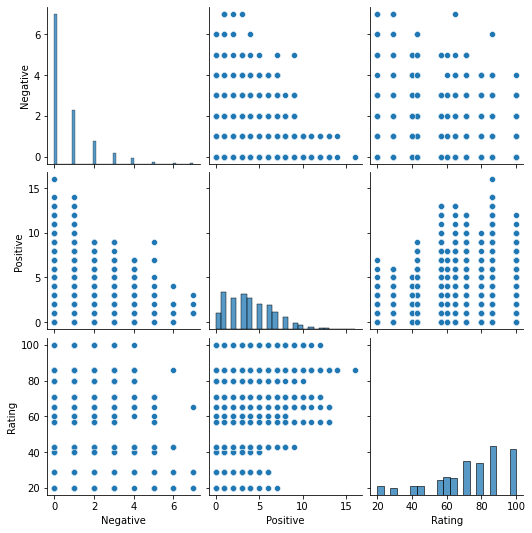

In [20]:
import seaborn as sns
cols = ['Negative', 'Positive', 'Rating']
sns_plot = sns.pairplot(df_train[cols])
sns_plot

Попробуем обучить нашу модель как задачу классификации, так и регрессии.
Очевидно на трейне модель классификации будет лучше, но на нашем тесте могут появиться новые значения рейтинга, так что ... 

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [61]:
X = df_train.drop(columns='Rating', axis = 1)
Y = df_train['Rating']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [23]:
X_train.head()

,Hotel_name,Review_Title,Review_Text,Review_Stemming,Review_Lemmiting,Positive,Negative
1503,The Spring,Perfect location for US Visa,"Hotel is superb in terms of facilities, cleanl...",hotel superb term facil cleanli perfect locat ...,hotel superb term facility cleanliness perfect...,3,0
1420,Aryaas,normal,nalla hotel. Reseption very bad. 2013 la stay ...,nalla hotel resept bad 2013 la stay panena ana...,nalla hotel reseption bad 2013 la stay panena ...,5,2
1763,The Checkers,good hotel to stay,However the service of one staff was not satis...,howev servic one staff satisfactori negoti aut...,however service one staff satisfactory negotia...,1,2
1356,The Residency Towers,Great location and good services,24 hrs check-in is the best part about this ho...,24 hrs check-in best part hotel servic great s...,24 hrs check-in best part hotel service great ...,8,0
1117,Raj Park Chennai,Good stay,Please improve the room service. Rooms are not...,pleas improv room servic room clean daili basi...,please improve room service room clean daily b...,6,0


### рассмотрим подходы bag of words и TF-IDF

Создадим два варианта, на стемминге и на леммитинге

In [62]:
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
X_train_cv_st=cv.fit_transform(X_train['Review_Stemming']).todense()
X_test_cv_st=cv.transform(X_test['Review_Stemming']).todense()

X_train_cv_st = np.append(X_train_cv_st, np.array(X_train.Positive).reshape([-1, 1]), axis=1)
X_test_cv_st = np.append(X_test_cv_st, np.array(X_test.Positive).reshape([-1, 1]), axis=1)

print('BOW_cv_train:',X_train_cv_st.shape)
print('BOW_cv_test:',X_test_cv_st.shape)

BOW_cv_train: (1645, 34348)
BOW_cv_test: (706, 34348)


In [63]:
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
X_train_cv_lm=cv.fit_transform(X_train['Review_Lemmiting']).todense()
X_test_cv_lm=cv.transform(X_test['Review_Lemmiting']).todense()

X_train_cv_lm = np.append(X_train_cv_lm, np.array(X_train.Positive).reshape([-1, 1]), axis=1)
X_test_cv_lm = np.append(X_test_cv_lm, np.array(X_test.Positive).reshape([-1, 1]), axis=1)

print('BOW_cv_train:',X_train_cv_lm.shape)
print('BOW_cv_test:',X_test_cv_lm.shape)

BOW_cv_train: (1645, 34681)
BOW_cv_test: (706, 34681)


In [64]:
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True, ngram_range=(1,3))
X_train_tv_st=tv.fit_transform(X_train['Review_Stemming']).todense()
X_test_tv_st=tv.transform(X_test['Review_Stemming']).todense()

X_train_tv_st = np.append(X_train_tv_st, np.array(X_train.Positive).reshape([-1, 1]), axis=1)
X_test_tv_st = np.append(X_test_tv_st, np.array(X_test.Positive).reshape([-1, 1]), axis=1)

print('Tfidf_train:',X_train_tv_st.shape)
print('Tfidf_test:',X_test_tv_st.shape)

Tfidf_train: (1645, 34348)
Tfidf_test: (706, 34348)


In [65]:
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True, ngram_range=(1,3))
X_train_tv_lm=tv.fit_transform(X_train['Review_Lemmiting']).todense()
X_test_tv_lm=tv.transform(X_test['Review_Lemmiting']).todense()

X_train_tv_lm = np.append(X_train_tv_lm, np.array(X_train.Positive).reshape([-1, 1]), axis=1)
X_test_tv_lm = np.append(X_test_tv_lm, np.array(X_test.Positive).reshape([-1, 1]), axis=1)

print('Tfidf_train:',X_train_tv_lm.shape)
print('Tfidf_test:',X_test_tv_lm.shape)

Tfidf_train: (1645, 34681)
Tfidf_test: (706, 34681)


### Классификация

In [66]:
from sklearn.ensemble import RandomForestClassifier
#from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn import metrics

In [31]:
import warnings

warnings.filterwarnings('ignore')

In [43]:
st_cv = [X_train_cv_st, X_test_cv_st]
st_tv = [X_train_tv_st, X_test_tv_st]
lm_tv = [X_train_tv_lm, X_test_tv_lm]
lm_cv = [X_train_cv_lm, X_test_cv_lm]

for p in [st_cv, lm_cv, st_tv, lm_tv]:
    log_reg = LogisticRegression(max_iter=300) 
    log_reg.fit(p[0], y_train)
    y_pred_log = log_reg.predict(p[1])


    svm = SVC()
    svm.fit(p[0], y_train)
    y_pred_svm = svm.predict(p[1])


    #knn = KNeighborsClassifier()
    #knn.fit(p[0], y_train)
    #y_pred_knn = knn.predict(p[1])
    #показывает плохие резы и оч долго работает

    forest = RandomForestClassifier(n_estimators=300, random_state=42)
    forest.fit(p[0], y_train)
    y_pred_forest = forest.predict(p[1])

    metric = [y_pred_forest, y_pred_log, y_pred_svm]
    strings = ['Forest', 'LogisticRegression', 'SVM']

    for m in range(3):
        print(f'model: {strings[m]}')
        print(f'Accuracy: {round(accuracy_score(y_test, metric[m]), 3)}')
        print(f'Precision macro: {round(precision_score(y_test, metric[m], average="macro"), 3)}')
        print(f'Recall macro: {round(recall_score(y_test, metric[m], average="macro"), 3)}')
        print(f'F1 macro: {round(f1_score(y_test, metric[m], average="macro"), 3)}')
        print('-'*30, '\n')
    print('\n')




model: Forest
Accuracy: 0.384
Precision macro: 0.66
Recall macro: 0.275
F1 macro: 0.309
------------------------------ 

model: LogisticRegression
Accuracy: 0.398
Precision macro: 0.704
Recall macro: 0.273
F1 macro: 0.3
------------------------------ 

model: SVM
Accuracy: 0.313
Precision macro: 0.716
Recall macro: 0.198
F1 macro: 0.193
------------------------------ 



model: Forest
Accuracy: 0.385
Precision macro: 0.661
Recall macro: 0.276
F1 macro: 0.31
------------------------------ 

model: LogisticRegression
Accuracy: 0.397
Precision macro: 0.7
Recall macro: 0.273
F1 macro: 0.3
------------------------------ 

model: SVM
Accuracy: 0.314
Precision macro: 0.716
Recall macro: 0.201
F1 macro: 0.199
------------------------------ 



model: Forest
Accuracy: 0.382
Precision macro: 0.658
Recall macro: 0.273
F1 macro: 0.305
------------------------------ 

model: LogisticRegression
Accuracy: 0.373
Precision macro: 0.537
Recall macro: 0.229
F1 macro: 0.222
------------------------------ 

ЫЫ все ужасно 

### Регрессия

In [32]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor

In [35]:
st_cv = [X_train_cv_st, X_test_cv_st]
st_tv = [X_train_tv_st, X_test_tv_st]
lm_tv = [X_train_tv_lm, X_test_tv_lm]
lm_cv = [X_train_cv_lm, X_test_cv_lm]

for p in [st_cv, lm_cv, st_tv, lm_tv]:
    linreg = LinearRegression()
    linreg.fit(p[0], y_train)
    linreg_pred = linreg.predict(p[1])
    print(f'MSE : {round(mean_squared_error(y_test, linreg_pred), 3)}' )

MSE : 2.078399147901019e+26
MSE : 7.0574436649049804e+25
MSE : 7.382938232721278e+22
MSE : 3.2687796565708043e+22


Попробуем использовать регурялизацию

In [36]:
from sklearn.model_selection import cross_val_score

In [42]:
st_cv = [X_train_cv_st, X_test_cv_st]
st_tv = [X_train_tv_st, X_test_tv_st]
lm_tv = [X_train_tv_lm, X_test_tv_lm]
lm_cv = [X_train_cv_lm, X_test_cv_lm]

for p in [st_cv, lm_cv, st_tv, lm_tv]:
    best_score = np.inf
    alphas = np.array([0.05, 0.08, 0.1, 0.15, 0.2, 0.3, 0.5, 1])
    for alpha in alphas:
        score = np.sqrt(-np.mean(cross_val_score(Ridge(alpha=alpha), p[0], y_train,scoring="neg_mean_squared_error", cv=5)))
        if best_score > score:
            best_score = score
            best_alpha = alpha
    print(f"Наилучший RMSE: {best_score} достигнут с коэффициентом: {best_alpha}.")

Наилучший RMSE: 21.141556108191573 достигнут с коэффициентом: 1.0.
Наилучший RMSE: 21.147108841185712 достигнут с коэффициентом: 1.0.
Наилучший RMSE: 20.276485380628746 достигнут с коэффициентом: 1.0.
Наилучший RMSE: 20.27674495802439 достигнут с коэффициентом: 1.0.


In [44]:
st_cv = [X_train_cv_st, X_test_cv_st]
st_tv = [X_train_tv_st, X_test_tv_st]
lm_tv = [X_train_tv_lm, X_test_tv_lm]
lm_cv = [X_train_cv_lm, X_test_cv_lm]

for p in [st_cv, lm_cv, st_tv, lm_tv]:
    best_score = np.inf
    alphas = np.array([0.05, 0.08, 0.1, 0.15, 0.2, 0.3, 0.5, 1])
    for alpha in alphas:
        score = np.sqrt(-np.mean(cross_val_score(Lasso(alpha=alpha), p[0], y_train,scoring="neg_mean_squared_error", cv=5)))
        if best_score > score:
            best_score = score
            best_alpha = alpha
    print(f"Наилучший RMSE: {best_score} достигнут с коэффициентом: {best_alpha}.")

Наилучший RMSE: 20.201487684095365 достигнут с коэффициентом: 0.15.
Наилучший RMSE: 20.201487684095365 достигнут с коэффициентом: 0.15.
Наилучший RMSE: 20.20143620976598 достигнут с коэффициентом: 0.05.
Наилучший RMSE: 20.20143620976598 достигнут с коэффициентом: 0.05.


кибербуллинг)

попробуем бустинг

In [93]:
from catboost import CatBoostRegressor
import catboost as cb
from sklearn.ensemble import RandomForestRegressor

In [ ]:
st_cv = [X_train_cv_st, X_test_cv_st]
st_tv = [X_train_tv_st, X_test_tv_st]
lm_tv = [X_train_tv_lm, X_test_tv_lm]
lm_cv = [X_train_cv_lm, X_test_cv_lm]



for p in [st_cv, lm_cv, st_tv, lm_tv]:
    yandex = cb.CatBoostRegressor(random_state=42)
    yandex.fit(p[0], y_train)
    yandex_pred = yandex.predict(p[1])
    print(f'RMSE: {round(np.sqrt(mean_squared_error(yandex_pred, y_test)), 3)}')

In [ ]:
st_cv = [X_train_cv_st, X_test_cv_st]
st_tv = [X_train_tv_st, X_test_tv_st]
lm_tv = [X_train_tv_lm, X_test_tv_lm]
lm_cv = [X_train_cv_lm, X_test_cv_lm]


for p in [st_cv, lm_cv, st_tv, lm_tv]:
    forest = RandomForestRegressor(n_estimators=300,random_state=42)
    forest.fit(p[0], y_train)
    forest_pred = forest.predict(X_test)
    
    print(f'RMSE: {round(np.sqrt(mean_squared_error(forest_pred, y_test)), 3)}')

### Тест

так как лучше всего себя показала линейная регрессия и логистическая регрессия, то обучим именно на них

In [96]:
df_test.head()

,Id,Hotel_name,Review_Title,Review_Text
0,2351,ITC Grand Chola,Mr Neeraj,On the night of my arrival from NY I had a min...
1,2352,Hotel Pandian,NaN,Not so great. But it is still acceptable. Bit...
2,2353,Oyo Rooms Guindy Olympia Tech Park,Nice stay for corporate people,Been a good place to stay for people who visit...
3,2354,OYO Apartments Saidapet,Average hotel,Not worth of the money we paid.worst ac.no wat...
4,2355,Ramada Chennai Egmore,A good mid range corporate hotel,"A well located hotel, with decent sized rooms ..."


In [97]:
df_sem.head()

,Id,Rating
0,2351,73.0
1,2352,73.0
2,2353,73.0
3,2354,73.0
4,2355,73.0


In [103]:
del df_sem['Id']

In [111]:
df_sem.head()

,Rating
0,73.0
1,73.0
2,73.0
3,73.0
4,73.0


In [104]:
df_test['Review'] = df_test.Review_Text.apply(lambda x: lemming(x))

In [106]:
df_test.head()

,Id,Hotel_name,Review_Title,Review_Text,Review
0,2351,ITC Grand Chola,Mr Neeraj,On the night of my arrival from NY I had a min...,night arrival ny minor problem room mr neeraj ...
1,2352,Hotel Pandian,NaN,Not so great. But it is still acceptable. Bit...,great still acceptable bit high money wise
2,2353,Oyo Rooms Guindy Olympia Tech Park,Nice stay for corporate people,Been a good place to stay for people who visit...,good place stay people visit olympia tech park...
3,2354,OYO Apartments Saidapet,Average hotel,Not worth of the money we paid.worst ac.no wat...,worth money paid.worst ac.no water.no cleaning...
4,2355,Ramada Chennai Egmore,A good mid range corporate hotel,"A well located hotel, with decent sized rooms ...",well locate hotel decent size room bit dated d...


In [107]:
df_test['Positive'] = df_test.Review.apply(lambda x: positive(x))
df_test['Negative'] = df_test.Review.apply(lambda x: negative(x))

In [108]:
df_test.head()

,Id,Hotel_name,Review_Title,Review_Text,Review,Positive,Negative
0,2351,ITC Grand Chola,Mr Neeraj,On the night of my arrival from NY I had a min...,night arrival ny minor problem room mr neeraj ...,5,3
1,2352,Hotel Pandian,NaN,Not so great. But it is still acceptable. Bit...,great still acceptable bit high money wise,2,0
2,2353,Oyo Rooms Guindy Olympia Tech Park,Nice stay for corporate people,Been a good place to stay for people who visit...,good place stay people visit olympia tech park...,5,0
3,2354,OYO Apartments Saidapet,Average hotel,Not worth of the money we paid.worst ac.no wat...,worth money paid.worst ac.no water.no cleaning...,1,0
4,2355,Ramada Chennai Egmore,A good mid range corporate hotel,"A well located hotel, with decent sized rooms ...",well locate hotel decent size room bit dated d...,9,0


In [117]:
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3), max_features=34680)
X1=cv.fit_transform(df_test.Review).todense()

X1 = np.append(X1, np.array(df_test.Positive).reshape([-1, 1]), axis=1)

In [101]:
X_train_new_lm_cv = np.append(X_train_cv_lm, X_test_cv_lm, axis=0)

In [102]:
y_train_new = np.append(y_train, y_test)

In [118]:
print(X_train_new_lm_cv.shape, y_train_new.shape, X1.shape, df_sem.shape)

(2351, 34681) (2351,) (2352, 34681) (2352, 1)


In [121]:
linreg = LinearRegression()

linreg.fit(X_train_new_lm_cv, y_train_new)
linreg_pred = linreg.predict(X1)
print(f'MSE : {round(mean_squared_error(df_sem, linreg_pred), 3)}' )

MSE : 1.4791850094401394e+26


логистическая регрессия


In [122]:
log_reg = LogisticRegression(max_iter=1000) 
log_reg.fit(X_train_new_lm_cv, y_train_new)
y_pred_log = log_reg.predict(X1)

In [ ]:
print(f'Accuracy: {round(accuracy_score(df_sem, y_pred_log), 3)}')
print(f'Precision macro: {round(precision_score(df_sem, y_pred_log, average="macro"), 3)}')
print(f'Recall macro: {round(recall_score(df_sem, y_pred_log, average="macro"), 3)}')
print(f'F1 macro: {round(f1_score(df_sem, y_pred_log, average="macro"), 3)}')